In [89]:
# # only for colab
# from google.colab import drive
# import os

# drive.mount("/content/gdrive")
# os.chdir('/content/gdrive/MyDrive/Projects/TESS/model_conditional_norm_flow/')
# ! ls

In [90]:
# ! rm -r log*

In [91]:
# Adapted from here: https://github.com/yolu1055/conditional-glow/tree/master

In [92]:
# @title Utils
import os
import torch
import numpy as np

def split_feature(tensor, type="split"):
    """
    type = ["split", "cross"]
    """
    C = tensor.size(1)
    if type == "split":
        return tensor[:, :C // 2, ...], tensor[:, C // 2:, ...]
    elif type == "cross":
        return tensor[:, 0::2, ...], tensor[:, 1::2, ...]


def save_model(model, optim, scheduler, dir, iteration):
    path = os.path.join(dir, "checkpoint_{}.pth.tar".format(iteration))
    state = {}
    state["iteration"] = iteration
    state["modelname"] = model.__class__.__name__
    state["model"] = model.state_dict()
    state["optim"] = optim.state_dict()
    if scheduler is not None:
        state["scheduler"] = scheduler.state_dict()
    else:
        state["scheduler"] = None

    torch.save(state, path)


def load_state(path, cuda):
    if cuda:
        print ("load to gpu")
        state = torch.load(path)
    else:
        print ("load to cpu")
        state = torch.load(path, map_location=lambda storage, loc: storage)

    return state


def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask].astype(int), minlength=n_class ** 2).reshape(n_class, n_class)
    return hist

def compute_accuracy(label_trues, label_preds, n_class):

    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [104]:
# @title Modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class ActNorm(nn.Module):

    def __init__(self, num_channels):
        super().__init__()

        size = [1, num_channels, 1, 1]

        bias = torch.normal(mean=torch.zeros(*size), std=torch.ones(*size)*0.05)
        logs = torch.normal(mean=torch.zeros(*size), std=torch.ones(*size)*0.05)
        self.register_parameter("bias", nn.Parameter(torch.Tensor(bias), requires_grad=True))
        self.register_parameter("logs", nn.Parameter(torch.Tensor(logs), requires_grad=True))


    def forward(self, input, logdet=0, reverse=False):
        dimentions = input.size(2) * input.size(3)
        if reverse == False:
            input = input + self.bias
            input = input * torch.exp(self.logs)
            dlogdet = torch.sum(self.logs) * dimentions
            logdet = logdet + dlogdet

        if reverse == True:
            input = input * torch.exp(-self.logs)
            input = input - self.bias
            dlogdet = - torch.sum(self.logs) * dimentions
            logdet = logdet + dlogdet

        return input, logdet


class Conv2dZeros(nn.Conv2d):

    def __init__(self, in_channel, out_channel, kernel_size=[3,3], stride=[1,1]):
        padding = (kernel_size[0] - 1) // 2
        super().__init__(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=stride, padding=padding)
        self.weight.data.normal_(mean=0.0, std=0.1)



class Conv2dResize(nn.Conv2d):

    def __init__(self, in_size, out_size):

        stride = [in_size[1]//out_size[1], in_size[2]//out_size[2]]
        kernel_size = Conv2dResize.compute_kernel_size(in_size, out_size, stride)
        super().__init__(in_channels=in_size[0], out_channels=out_size[0], kernel_size=kernel_size, stride=stride)
        self.weight.data.zero_()


    @staticmethod
    def compute_kernel_size(in_size, out_size, stride):
        k0 = in_size[1] - (out_size[1] - 1) * stride[0]
        k1 = in_size[2] - (out_size[2] - 1) * stride[1]
        return[k0,k1]



class Conv2dNorm(nn.Conv2d):

    def __init__(self, in_channels, out_channels, kernel_size=[3, 3], stride=[1, 1]):

        padding = (kernel_size[0] - 1) // 2
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)
        #initialize weight
        self.weight.data.normal_(mean=0.0, std=0.05)



class CondActNorm(nn.Module):

    def __init__(self, x_size, y_channels, x_hidden_channels, x_hidden_size):
        super().__init__()

        # OLD C_x,H_x,W_x = x_size
        C_x, H_x = x_size 

        # OLD conditioning network
        # self.x_Con = nn.Sequential(
        #     Conv2dResize(in_size=[C_x,H_x,W_x], out_size=[x_hidden_channels, H_x//2, W_x//2]),
        #     nn.ReLU(),
        #     Conv2dResize(in_size=[x_hidden_channels, H_x//2, W_x//2], out_size=[x_hidden_channels, H_x//4, W_x//4]),
        #     nn.ReLU(),
        #     Conv2dResize(in_size=[x_hidden_channels, H_x//4, W_x//4], out_size=[x_hidden_channels, H_x//8, W_x//8]),
        #     nn.ReLU()
        # )

        # NEW conditioning network
        self.x_Linear = nn.Sequential(
            nn.Linear(H_x, x_hidden_channels*H_x),
            nn.Tanh(),
            nn.Linear(x_hidden_channels*H_x, x_hidden_channels*H_x//2),
            nn.Tanh(),
            nn.Linear(x_hidden_channels*H_x//2, x_hidden_channels*H_x//4),
            nn.Tanh(),
            nn.Linear(x_hidden_channels*H_x//4, x_hidden_size),
            nn.Tanh(),
            nn.Linear(x_hidden_size, x_hidden_size),
            nn.Tanh(),
            nn.Linear(x_hidden_size, 2*y_channels),
            nn.Tanh()
        )


    def forward(self, x, y, logdet=0, reverse=False):
        
        B,C,H = x.size()
        print('xbefore', x.shape, x)
        # generate weights
        # x = self.x_Con(x)
        # x = x.view(B, -1)
        x = self.x_Linear(x)

        print('xafter', x.shape, x)

        x = x.view(B, -1, 1, 1)


        logs, bias = split_feature(x)
        dimentions = y.size(2) * y.size(3)


        if not reverse:
            # center and scale
            y = y + bias
            y = y * torch.exp(logs)
            dlogdet = dimentions * torch.sum(logs, dim=(1,2,3))
            logdet = logdet + dlogdet
        else:
            # scale and center
            y = y * torch.exp(-logs)
            y = y - bias
            dlogdet = - dimentions * torch.sum(logs, dim=(1,2,3))
            logdet = logdet + dlogdet

        return y, logdet



class Cond1x1Conv(nn.Module):

    def __init__(self, x_size, x_hidden_channels, x_hidden_size, y_channels):

        super().__init__()

        C_x,H_x = x_size


        # # conditioning network
        # self.x_Con = nn.Sequential(
        #     Conv2dResize(in_size=[C_x,H_x,W_x], out_size=[x_hidden_channels, H_x//2, W_x//2]),
        #     nn.ReLU(),
        #     Conv2dResize(in_size=[x_hidden_channels, H_x//2, W_x//2], out_size=[x_hidden_channels, H_x//4, W_x//4]),
        #     nn.ReLU(),
        #     Conv2dResize(in_size=[x_hidden_channels, H_x//4, W_x//4], out_size=[x_hidden_channels, H_x//8, W_x//8]),
        #     nn.ReLU()
        # )

        # NEW conditioning network

        self.x_Linear = nn.Sequential(
            LinearZeros(H_x, x_hidden_channels*H_x),
            nn.Tanh(),
            LinearZeros(x_hidden_channels*H_x, x_hidden_channels*H_x//2),
            nn.Tanh(),
            LinearZeros(x_hidden_channels*H_x//2, x_hidden_channels*H_x//4),
            nn.Tanh(),
            LinearZeros(x_hidden_channels*H_x//4, x_hidden_size),
            nn.Tanh(),
            LinearZeros(x_hidden_size, x_hidden_size),
            nn.Tanh(),
            LinearZeros(x_hidden_size, y_channels*y_channels),
            nn.Tanh()
        )


    def get_weight(self, x, y, reverse):
        y_channels = y.size(1)
        B,C,H = x.size()

        # x = self.x_Con(x)
        # x = x.view(B, -1)
        x = self.x_Linear(x)
        weight = x.view(B, y_channels, y_channels)
        

        dimensions = y.size(2) * y.size(3)
        dlogdet = torch.slogdet(weight)[1] * dimensions


        if reverse == False:
            weight = weight.view(B, y_channels, y_channels,1,1)

        else:
            weight = torch.inverse(weight.double()).float().view(B, y_channels, y_channels,1,1)

        return weight, dlogdet



    def forward(self, x, y, logdet=None, reverse=False):

        weight, dlogdet = self.get_weight(x, y, reverse)
        B,C,H,W = y.size()
        y = y.view(1, B*C, H, W)
        B_k, C_i_k, C_o_k, H_k, W_k = weight.size()
        assert B == B_k and C == C_i_k and C == C_o_k, "The input and kernel dimensions are different"
        weight = weight.reshape(B_k*C_i_k,C_o_k,H_k,W_k)

        if reverse == False:
            z = F.conv2d(y, weight, groups=B)
            z = z.view(B,C,H,W)
            if logdet is not None:
                logdet = logdet + dlogdet

            return z, logdet
        else:
            z = F.conv2d(y, weight, groups=B)
            z = z.view(B,C,H,W)

            if logdet is not None:
                logdet = logdet - dlogdet

            return z, logdet


class Conv2dNormy(nn.Conv2d):

    def __init__(self, in_channels, out_channels,
                 kernel_size=[3, 3], stride=[1, 1]):
        padding = [(kernel_size[0]-1)//2, (kernel_size[1]-1)//2]
        super().__init__(in_channels, out_channels, kernel_size, stride,
                         padding, bias=False)

        #initialize weight
        self.weight.data.normal_(mean=0.0, std=0.05)
        self.actnorm = ActNorm(out_channels)


    def forward(self, input):
        x = super().forward(input)
        x,_ = self.actnorm(x)
        return x


class Conv2dZerosy(nn.Conv2d):

    def __init__(self, in_channels, out_channels,
                 kernel_size=[3, 3], stride=[1, 1]):

        padding = [(kernel_size[0]-1)//2, (kernel_size[1]-1)//2]
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)

        self.logscale_factor = 3.0
        self.register_parameter("logs", nn.Parameter(torch.zeros(out_channels, 1, 1)))
        self.register_parameter("newbias", nn.Parameter(torch.zeros(out_channels, 1, 1)))

        # init
        self.weight.data.zero_()
        self.bias.data.zero_()

    def forward(self, input):
        output = super().forward(input)
        output = output + self.newbias
        output = output * torch.exp(self.logs * self.logscale_factor)
        return output




class CondAffineCoupling(nn.Module):

    def __init__(self, x_size, y_size, hidden_channels):
        super().__init__()

        # self.resize_x = nn.Sequential(
        #     Conv2dZeros(x_size[0], 16),
        #     nn.ReLU(),
        #     Conv2dResize((16,x_size[1],x_size[2]), out_size=y_size),
        #     nn.ReLU(),
        #     Conv2dZeros(y_size[0], y_size[0]),
        #     nn.ReLU()
        # )

        C_x, H_x = x_size

        self.resize_x = nn.Sequential(
            LinearZeros(H_x, 32),
            nn.Tanh(),
            LinearZeros(32, y_size[0]*y_size[1]*y_size[2]),
            nn.Tanh(),
            LinearZeros(y_size[0]*y_size[1]*y_size[2], y_size[0]*y_size[1]*y_size[2]),
            nn.Tanh()
        )

        self.f = nn.Sequential(
            Conv2dNormy(y_size[0]*2, hidden_channels),
            nn.ReLU(),
            Conv2dNormy(hidden_channels, hidden_channels, kernel_size=[1, 1]),
            nn.ReLU(),
            Conv2dZerosy(hidden_channels, 2*y_size[0]),
            nn.Tanh()
        )

    def forward(self, x, y, logdet=0.0, reverse=False):

        z1, z2 = split_feature(y, "split")
        x = self.resize_x(x)
        x = x.view(z1.shape)

        h = torch.cat((x,z1), dim=1)
        h = self.f(h)
        shift, scale = split_feature(h, "cross")
        scale = torch.sigmoid(scale + 2.)
        if reverse == False:
            z2 = z2 + shift
            z2 = z2 * scale
            logdet = torch.sum(torch.log(scale), dim=(1, 2, 3)) + logdet

        if reverse == True:
            z2 = z2 / scale
            z2 = z2 - shift
            logdet = -torch.sum(torch.log(scale), dim=(1, 2, 3)) + logdet

        z = torch.cat((z1, z2), dim=1)

        return z, logdet



class SqueezeLayer(nn.Module):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor

    def forward(self, input, logdet=None, reverse=False):
        if not reverse:
            output = SqueezeLayer.squeeze2d(input, self.factor)
            return output, logdet
        else:
            output = SqueezeLayer.unsqueeze2d(input, self.factor)
            return output, logdet


    @staticmethod
    def squeeze2d(input, factor=2):
        assert factor >= 1 and isinstance(factor, int)
        if factor == 1:
            return input
        B, C, H, W = input.size()
        assert H % factor == 0 and W % factor == 0, "{}".format((H, W))
        x = input.view(B, C, H // factor, factor, W // factor, factor)
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
        x = x.view(B, C * factor * factor, H // factor, W // factor)
        return x


    @staticmethod
    def unsqueeze2d(input, factor=2):
        assert factor >= 1 and isinstance(factor, int)
        factor2 = factor ** 2
        if factor == 1:
            return input
        B, C, H, W = input.size()
        assert C % (factor2) == 0, "{}".format(C)
        x = input.view(B, C // factor2, factor, factor, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
        x = x.view(B, C // (factor2), H * factor, W * factor)
        return x


class Split2d(nn.Module):
    def __init__(self, num_channels):
        super().__init__()

        self.conv = nn.Sequential(
            Conv2dZeros(num_channels // 2, num_channels),
            nn.Tanh()
        )

    def split2d_prior(self, z):
        h = self.conv(z)
        return split_feature(h, "cross")

    def forward(self, input, logdet=0., reverse=False, eps_std=None):
        if not reverse:
            z1, z2 = split_feature(input, "split")
            mean, logs = self.split2d_prior(z1)
            logdet = GaussianDiag.logp(mean, logs, z2) + logdet

            return z1, logdet
        else:
            z1 = input
            mean, logs = self.split2d_prior(z1)
            z2 = GaussianDiag.sample(mean, logs, eps_std)
            z = torch.cat((z1, z2), dim=1)

            return z, logdet


class GaussianDiag:
    Log2PI = float(np.log(2 * np.pi))

    @staticmethod
    def likelihood(mean, logs, x):
        return -0.5 * (logs * 2. + ((x - mean) ** 2.) / torch.exp(logs * 2.) + GaussianDiag.Log2PI)

    @staticmethod
    def logp(mean, logs, x):
        likelihood = GaussianDiag.likelihood(mean, logs, x)
        return torch.sum(likelihood, dim=(1, 2, 3))

    @staticmethod
    def sample(mean, logs, eps_std=None):
        eps_std = eps_std or 1
        eps = torch.normal(mean=torch.zeros_like(mean),
                           std=torch.ones_like(logs) * eps_std)
        return mean + torch.exp(logs) * eps

    @staticmethod
    def batchsample(batchsize, mean, logs, eps_std=None):
        eps_std = eps_std or 1
        sample = GaussianDiag.sample(mean, logs, eps_std)
        for i in range(1, batchsize):
            s = GaussianDiag.sample(mean, logs, eps_std)
            sample = torch.cat((sample, s), dim=0)
        return sample



class LinearZeros(nn.Linear):

    def __init__(self, in_channels, out_channels):
        super().__init__(in_channels, out_channels)
        self.weight.data.zero_()
        self.bias.data.zero_()

    def forward(self, input):
        output = super().forward(input)
        return output


class LinearNorm(nn.Linear):

    def __init__(self, in_channels, out_channels):
        super().__init__(in_channels, out_channels)
        self.weight.data.normal_(mean=0.0, std=0.1)
        self.bias.data.normal_(mean=0.0, std=0.1)


In [94]:
# @title Glow Model
import torch
import torch.nn as nn
import numpy as np

class CondGlowStep(nn.Module):

    def __init__(self, x_size, y_size, x_hidden_channels, x_hidden_size, y_hidden_channels):


        super().__init__()

        # 1. cond-actnorm
        self.actnorm = CondActNorm(x_size=x_size, y_channels=y_size[0], x_hidden_channels=x_hidden_channels, x_hidden_size=x_hidden_size)

        # 2. cond-1x1conv
        self.invconv = Cond1x1Conv(x_size=x_size, x_hidden_channels=x_hidden_channels, x_hidden_size=x_hidden_size, y_channels=y_size[0])

        # 3. cond-affine
        self.affine = CondAffineCoupling(x_size=x_size, y_size=[y_size[0] // 2, y_size[1], y_size[2]], hidden_channels=y_hidden_channels)


    def forward(self, x, y, logdet=None, reverse=False):
        
        if reverse is False:
            # 1. cond-actnorm
            y, logdet = self.actnorm(x, y, logdet, reverse=False)

            # 2. cond-1x1conv
            y, logdet = self.invconv(x, y, logdet, reverse=False)

            # 3. cond-affine
            y, logdet = self.affine(x, y, logdet, reverse=False)

            # Return
            return y, logdet


        if reverse is True:
            # 3. cond-affine
            y, logdet = self.affine(x, y, logdet, reverse=True)

            # 2. cond-1x1conv
            y, logdet = self.invconv(x, y, logdet, reverse=True)

            # 1. cond-actnorm
            y, logdet = self.actnorm(x, y, logdet, reverse=True)

            # Return
            return y, logdet


class CondGlow(nn.Module):

    def __init__(self, x_size, y_size, x_hidden_channels, x_hidden_size, y_hidden_channels, K, L):


        super().__init__()
        self.layers = nn.ModuleList()
        self.output_shapes = []
        self.K = K
        self.L = L
        C, H, W = y_size

        for l in range(0, L):

            # 1. Squeeze
            C, H, W = C * 4, H // 2, W // 2
            y_size = [C,H,W]
            self.layers.append(SqueezeLayer(factor=2))
            self.output_shapes.append([-1, C, H, W])

            # 2. K CGlowStep
            for k in range(0, K):

                self.layers.append(CondGlowStep(x_size = x_size,
                                            y_size = y_size,
                                            x_hidden_channels = x_hidden_channels,
                                            x_hidden_size = x_hidden_size,
                                            y_hidden_channels = y_hidden_channels,
                                            )
                                   )

                self.output_shapes.append([-1, C, H, W])

            # 3. Split
            if l < L - 1:
                self.layers.append(Split2d(num_channels=C))
                self.output_shapes.append([-1, C // 2, H, W])
                C = C // 2


    def forward(self, x, y, logdet=0.0, reverse=False, eps_std=1.0):
        if reverse == False:
            return self.encode(x, y, logdet)
        else:
            return self.decode(x, y, logdet, eps_std)

    def encode(self, x, y, logdet=0.0):
        for layer, shape in zip(self.layers, self.output_shapes):
            if isinstance(layer, Split2d) or isinstance(layer, SqueezeLayer):
                y, logdet = layer(y, logdet, reverse=False)

            else:
                y, logdet = layer(x, y, logdet, reverse=False)
        return y, logdet

    def decode(self, x, y, logdet=0.0, eps_std=1.0):
        for layer in reversed(self.layers):
            if isinstance(layer, Split2d):
                y, logdet = layer(y, logdet=logdet, reverse=True, eps_std=eps_std)

            elif isinstance(layer, SqueezeLayer):
                y, logdet = layer(y, logdet=logdet, reverse=True)

            else:
                y, logdet = layer(x, y, logdet=logdet, reverse=True)

        return y, logdet


class CondGlowModel(nn.Module):
    BCE = nn.BCEWithLogitsLoss()
    CE = nn.CrossEntropyLoss()

    def __init__(self, args):
        super().__init__()
        self.flow = CondGlow(x_size=args.x_size,
                            y_size=args.y_size,
                            x_hidden_channels=args.x_hidden_channels,
                            x_hidden_size=args.x_hidden_size,
                            y_hidden_channels=args.y_hidden_channels,
                            K=args.depth_flow,
                            L=args.num_levels,
                            )

        self.learn_top = args.learn_top


        self.register_parameter("new_mean",
                                nn.Parameter(torch.zeros(
                                    [1,
                                     self.flow.output_shapes[-1][1],
                                     self.flow.output_shapes[-1][2],
                                     self.flow.output_shapes[-1][3]])))


        self.register_parameter("new_logs",
                                nn.Parameter(torch.zeros(
                                    [1,
                                     self.flow.output_shapes[-1][1],
                                     self.flow.output_shapes[-1][2],
                                     self.flow.output_shapes[-1][3]])))

        self.n_bins = args.y_bins


    def prior(self):

        if self.learn_top:
            return self.new_mean, self.new_logs
        else:
            return torch.zeros_like(self.new_mean), torch.zeros_like(self.new_logs)


    def forward(self, x=0.0, y=None, eps_std=1.0, reverse=False):
        if reverse == False:
            dimensions = y.size(1)*y.size(2)*y.size(3)
            logdet = torch.zeros_like(y[:, 0, 0, 0])
            logdet += float(-np.log(self.n_bins) * dimensions)
            z, objective = self.flow(x, y, logdet=logdet, reverse=False)
            mean, logs = self.prior()
            objective += GaussianDiag.logp(mean, logs, z)
            nll = -objective / float(np.log(2.) * dimensions)
            return z, nll

        else:
            with torch.no_grad():
                mean, logs = self.prior()
                if y is None:
                    y = GaussianDiag.batchsample(x.size(0), mean, logs, eps_std)
                y, logdet = self.flow(x, y, eps_std=eps_std, reverse=True)
            return y, logdet

In [7]:
# @title Learner
import os
import torch
import datetime
import numpy as np
from torch.utils.data import DataLoader
import time
# from datasets import convert_to_img
# from datasets import preprocess
# from datasets import postprocess
from torchvision.utils import save_image
import matplotlib.pyplot as plt


class Trainer(object):

    def __init__(self, graph, optim, scheduler, trainingset, validset, args, cuda):

        # set path and date
        date = str(datetime.datetime.now())
        date = date[:date.rfind(":")].replace("-", "")\
                                     .replace(":", "")\
                                     .replace(" ", "_")
        self.log_dir = os.path.join(args.log_root, "log_" + date)
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)


        self.checkpoints_dir = os.path.join(self.log_dir, "checkpoints")
        if not os.path.exists(self.checkpoints_dir):
            os.makedirs(self.checkpoints_dir)

        self.images_dir = os.path.join(self.log_dir, "images")
        if not os.path.exists(self.images_dir):
            os.makedirs(self.images_dir)

        self.valid_samples_dir = os.path.join(self.log_dir, "valid_samples")
        if not os.path.exists(self.valid_samples_dir):
            os.makedirs(self.valid_samples_dir)



        # model
        self.graph = graph
        self.optim = optim
        self.scheduler = scheduler

        # gradient bound
        self.max_grad_clip = args.max_grad_clip
        self.max_grad_norm = args.max_grad_norm

        # data
        self.dataset_name = args.dataset_name
        self.batch_size = args.batch_size
        self.trainingset_loader = DataLoader(trainingset,
                                      batch_size=self.batch_size,
                                      shuffle=True,
                                      drop_last=True)

        self.validset_loader = DataLoader(validset,
                                      batch_size=self.batch_size,
                                      shuffle=False,
                                      drop_last=False)

        self.num_epochs = args.num_epochs
        self.global_step = args.num_steps
        self.label_scale = args.label_scale
        self.label_bias = args.label_bias
        self.x_bins = args.x_bins
        self.y_bins = args.y_bins


        self.num_epochs = args.num_epochs
        self.nll_gap = args.nll_gap
        self.inference_gap = args.inference_gap
        self.checkpoints_gap = args.checkpoints_gap
        self.save_gap = args.save_gap

        # device
        self.cuda = cuda

    def validate(self):
        print ("Start Validating")
        self.graph.eval()
        mean_loss = list()
        samples = list()
        with torch.no_grad():
            for i_batch, batch in enumerate(self.validset_loader):
                x = batch["x"]
                y = batch["y"]

                if self.cuda:
                    x = x.cuda()
                    y = y.cuda()


                # forward
                z, nll = self.graph(x,y)
                loss = torch.mean(nll)
                mean_loss.append(loss.data.cpu().item())

                # true label
                y_true = y

                # sample
                batch_samples = []
                for b in range(len(y)):
                    row = []
                    row.append(y_true[b])
                    batch_samples.append(row)
                for i in range(0, 5):
                    y_sample,_ = self.graph(x, y=None, reverse=True)

                    for b in range(len(y)):
                        batch_samples[b].append(y_sample[b])

                for b in range(len(y)):
                    samples.append(batch_samples[b])

        # save samples
        for i in range(0, len(samples)):
            if i < 5:
                fig, axes = plt.subplots(1, len(samples[i]), figsize=(40, 7))
                for b in range(0,len(samples[i])):
                    plottitle = 'y true' if b == 0 else f'(Using only x_cond) sample {b}'
                    axes[b].set_title(plottitle)
                    im_pred = axes[b].imshow(samples[i][b].cpu()[0], cmap="gray")
                    fig.colorbar(im_pred, fraction=0.046, pad=0.04)
                fig.savefig(os.path.join(self.valid_samples_dir, f"global_step{self.global_step}_sample{i}_batch{b}.pdf"))
                plt.close()

        # save loss
        mean = np.mean(mean_loss)
        with open(os.path.join(self.log_dir, "valid_NLL.txt"), "a") as nll_file:
            nll_file.write(str(self.global_step) + "\t" + "{:.5f}".format(mean) + "\n")
        print ("Finish Validating")
        self.graph.train()


    def train(self):

        self.graph.train()

        starttime = time.time()

        # run
        num_batchs = len(self.trainingset_loader)
        total_its = self.num_epochs * num_batchs
        for epoch in range(self.num_epochs):
            mean_nll = 0.0
            for _, batch in enumerate(self.trainingset_loader):
                self.optim.zero_grad()

                x = batch["x"]
                y = batch["y"]


                if self.cuda:
                    x = x.cuda()
                    y = y.cuda()

                # forward
                z, nll = self.graph(x, y)


                # loss
                loss = torch.mean(nll)
                mean_nll = mean_nll + loss.data

                # backward
                self.graph.zero_grad()
                self.optim.zero_grad()
                loss.backward()

                # operate grad
                if self.max_grad_clip > 0:
                    torch.nn.utils.clip_grad_value_(self.graph.parameters(), self.max_grad_clip)
                if self.max_grad_norm > 0:
                    torch.nn.utils.clip_grad_norm_(self.graph.parameters(), self.max_grad_norm)

                # step
                self.optim.step()

                currenttime = time.time()
                elapsed = currenttime - starttime
                print("Iteration: {}/{} \t Elapsed time: {:.2f} \t Loss:{:.5f}".format(self.global_step, total_its, elapsed, loss.data))

                if self.global_step % self.nll_gap == 0:
                    with open(os.path.join(self.log_dir, "NLL.txt"), "a") as nll_file:
                        nll_file.write(str(self.global_step) + " \t " + "{:.2f} \t {:.5f}".format(elapsed, loss.data) + "\n")



                # checkpoint
                if self.global_step % self.checkpoints_gap == 0 and self.global_step > 0:
                    self.validate()

                    # samples
                    samples = []
                    for b in range(self.batch_size):
                        samples.append([])

                    for i in range(0,5):
                        y_sample,_ = self.graph(x, y=None, reverse=True)
                        for b in range(self.batch_size):
                            samples[b].append(y_sample[b])

                    # inverse image
                    y_inverse,_ = self.graph(x, y=z, reverse=True)

                    # true label
                    y_true = y


                    # save images
                    output = None
                    for b in range(0, self.batch_size):

                        fig, axes = plt.subplots(1, 3, figsize=(20, 8))

                        if b < 5:
                            axes[0].set_title('y Truth')
                            im_true = axes[0].imshow(y[b].cpu()[0], cmap="gray")
                            fig.colorbar(im_true, fraction=0.046, pad=0.04)

                            axes[1].set_title('y inverse')
                            im_latent = axes[1].imshow(y_inverse[b].cpu()[0], cmap="gray")
                            fig.colorbar(im_latent, fraction=0.046, pad=0.04)

                            axes[2].set_title('y Prediction sample')
                            im_pred = axes[2].imshow(samples[b][i].cpu()[0], cmap="gray")
                            fig.colorbar(im_pred, fraction=0.046, pad=0.04)

                            fig.savefig(os.path.join(self.images_dir, f"global_step-{self.global_step}_batch_{b}.pdf"))
                            plt.close()



                # save model
                if self.global_step % self.save_gap == 0 and self.global_step > 0:
                    save_model(self.graph, self.optim, self.scheduler, self.checkpoints_dir, self.global_step)


                self.global_step = self.global_step + 1

            if self.scheduler is not None:
                self.scheduler.step()
            mean_nll = float(mean_nll / float(num_batchs))
            with open(os.path.join(self.log_dir, "Epoch_NLL.txt"), "a") as f:
                currenttime = time.time()
                elapsed = currenttime - starttime
                f.write("{} \t {:.2f}\t {:.5f}".format(epoch, elapsed, mean_nll) + "\n")




class Inferencer(object):

    def __init__(self, model, dataset, args, cuda):

        # set path and date
        self.out_root = args.out_root
        if not os.path.exists(self.out_root):
            os.makedirs(self.out_root)

        # cuda
        self.cuda = cuda

        # model
        self.model = model


        # data
        self.dataset_name = args.dataset_name
        self.batch_size = args.batch_size
        self.data_loader = DataLoader(dataset,
                                      batch_size=self.batch_size,
                                      shuffle=False,
                                      drop_last=False)

        self.label_scale = args.label_scale
        self.label_bias = args.label_bias
        self.num_labels = args.num_labels
        self.y_bins = args.y_bins
        self.x_bins = args.x_bins


    def sampled_based_prediction(self, n_samples):
        metrics = []
        start = time.time()
        for i_batch, batch in enumerate(self.data_loader):
            print(f"Batch IDs: {i_batch}")

            x = batch["x"]
            y = batch["y"]

            if self.cuda:
                x = x.cuda()
                y = y.cuda()

            sample_list = list()
            nll_list = list()
            for i in range(0, n_samples):

                print(f"Samples: {i}/{n_samples}")

                # z, nll = self.model(x, y, reverse=False)
                # ypred, logdet = self.model(x, z, reverse=True)

                y_sample,_ = self.model(x, reverse=True)
                _, nll = self.model(x,y_sample)
                loss = torch.mean(nll)
                sample_list.append(y_sample)
                nll_list.append(loss.data.cpu().numpy())

            sample = torch.stack(sample_list)
            sample = torch.mean(sample, dim=0, keepdim=False)
            nll = np.mean(nll_list)

            y_pred_imgs = sample
            y_true_imgs = y

            # save trues and preds
            output = []
            for i in range(0, len(y_true_imgs)):
                true_img = y_true_imgs[i]
                pred_img = y_pred_imgs[i]
                row = [x[i].cpu(), true_img, pred_img]
                output.append(row)

                fig, axes = plt.subplots(1, 3, figsize=(20, 8))

                axes[0].set_title('Truth')
                im_true = axes[0].imshow(true_img.cpu()[0], cmap="gray")
                fig.colorbar(im_true, fraction=0.046, pad=0.04)

                axes[1].set_title('x_cond')
                im_latent = axes[1].imshow(x[i].cpu()[0], cmap="gray")
                fig.colorbar(im_latent, fraction=0.046, pad=0.04)

                axes[2].set_title('Prediction')
                im_pred = axes[2].imshow(pred_img.cpu()[0], cmap="gray")
                fig.colorbar(im_pred, fraction=0.046, pad=0.04)

                fig.savefig(os.path.join(self.out_root, f"batch_{i_batch}-{i}.pdf"))
                plt.close()


In [8]:
# # @title Datasets
# import os
# import numpy as np
# import torch
# import PIL.Image as Image
# from torch.utils import data
# import torchvision.transforms as transforms


# class HorseDataset(data.Dataset):

#     def __init__(self, dir, size, n_c, portion="train"):
#         self.dir = dir
#         self.names = self.read_names(dir, portion)
#         self.n_c = n_c
#         self.size = size

#     def read_names(self, dir, portion):

#         path = os.path.join(dir, "{}.txt".format(portion))
#         names = list()
#         with open(path, "r") as f:
#             for line in f:
#                 line = line.strip()
#                 name = {}
#                 name["img"] = os.path.join(dir, os.path.join("images", line))
#                 name["lbl"] = os.path.join(dir, os.path.join("labels", line))
#                 names.append(name)
#         return names

#     def __len__(self):
#         return len(self.names)


#     def __getitem__(self, index):

#         # path
#         name = self.names[index]
#         img_path = name["img"]
#         lbl_path = name["lbl"]
#         transform = transforms.Compose([transforms.Resize(self.size), transforms.ToTensor()])

#         # img
#         img = Image.open(img_path).convert("RGB")
#         img = transform(img)

#         # lbl
#         lbl = Image.open(lbl_path).convert("L")
#         lbl = transform(lbl)
#         lbl = torch.round(lbl)
#         if self.n_c > 1:
#             lbl = lbl.repeat(self.n_c,1,1)

#         return {"x":img, "y":lbl}

In [26]:
# @title TESS Dataset
import os
from PIL import Image
import torch
import pickle
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

class TESSDataset(Dataset):
    def __init__(self):

        # self.data = []
        # self.labels = []

        # get data
        angle_folder = "/pdo/users/jlupoiii/TESS/data/angles/"
        ccd_folder = "/pdo/users/jlupoiii/TESS/data/ccds/"

        # data matrices
        X = []
        Y = []
        ffis = []

        angles_dic = pickle.load(open(angle_folder+'angles_O13_data.pkl', "rb"))

        for filename in os.listdir(ccd_folder):
            if len(filename) < 40 or filename[27] != '3': continue

            image_arr = pickle.load(open(ccd_folder+filename, "rb"))
            ffi_num = filename[18:18+8]
            try:
                angles = angles_dic[ffi_num]
                # print('Got ffi number', ffi_num)
            except:
                # print('Could not find ffi with number:', ffi_num)
                continue
            X.append(np.array([angles[10], angles[11], angles[18], angles[19], angles[22], angles[23], angles[24], angles[25]]))
            Y.append(image_arr.flatten())
            ffis.append(ffi_num)

        # X = np.array(X)
        # Y = np.array(Y)
        # ffis = np.array(ffis)
        # we are calculating Y GIVEN X
        self.data = [Image.fromarray(x) for x in X]
        self.labels = [Image.fromarray(y) for y in Y]
        self.ffis = ffis

        # for s in self.labels:
        #     print(s.size)
        #     # print(np.array(s).reshape((16,16))
            
        #     plt.imshow(np.array(s).reshape((16,16)))
        #     plt.show()
        #     plt.close()



        # for class_idx, class_name in enumerate(self.classes):
        #     # print(class_idx)
        #     horse_img_path = os.path.join(self.root_dir, "horse", class_name)
        #     mask_img_path = os.path.join(self.root_dir, "mask", class_name)

        #     horse_image = Image.open(horse_img_path).convert('RGB')
        #     mask_image = Image.open(mask_img_path).convert('L')

        #     self.data.extend([horse_image])
        #     self.labels.extend([mask_image])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # horse_img_path, mask_img_path = self.data[idx], self.labels[idx]
        # label = self.labels[idx]
        # horse_image = Image.open(horse_img_path).convert('RGB')
        # mask_image = Image.open(mask_img_path).convert('L')

        angles_image = self.data[idx]
        ffi_image = self.labels[idx]

        transform = transforms.Compose([
            # transforms.Resize((1, 8)),
            transforms.ToTensor(),
            lambda s: s.reshape(1, 8),
            # transforms.Normalize(mean=[0.456], std=[0.225])
        ])
        target_transform = transforms.Compose([
            lambda s: np.array(s),
            lambda s: s.reshape((16,16)),
            # transforms.Resize((16, 16)),
            transforms.ToTensor()
        ])

        angles_image = transform(angles_image)
        ffi_image = target_transform(ffi_image)
        
        # return x=angles, y=ffis
        # we are calculating X GIVEN Y
        return {"x":angles_image, "y":ffi_image}

693
torch.Size([1, 8])
torch.Size([1, 16, 16])
x tensor([1.0840e+02, 2.5450e+02, 8.2900e+01, 2.0540e+02, 1.7007e-02, 1.4184e-02,
        2.8923e-04, 2.0120e-04])


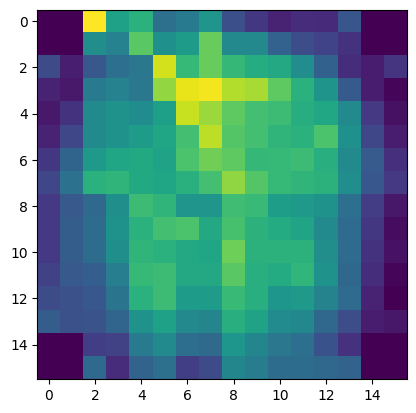

In [70]:
# we are calculating Y GIVEN X
tess_dataset = TESSDataset()
print(len(tess_dataset))
print(tess_dataset[1]['x'].shape)
print(tess_dataset[1]['y'].shape)

# plt.plot(tess_dataset[1]['x'][0])
print('x', tess_dataset[1]['x'][0])
plt.show()
plt.close()

plt.imshow(tess_dataset[1]['y'][0])
plt.show()
plt.close()

In [105]:
# @title Train
import argparse
import torch
from torchvision import datasets
# import Learner
# import datasets
# import utils
# from CGlowModel import CondGlowModel


if __name__=="__main__":

    parser = argparse.ArgumentParser(description='train c-Glow')

    # input output path
    parser.add_argument("-d", "--dataset_name", type=str, default="horse")
    parser.add_argument("-r", "--dataset_root", type=str, default="weizmann_horse_db")

    # log root
    parser.add_argument("--log_root", type=str, default="")

    # C-Glow parameters
    # we are calculating Y GIVEN X
    parser.add_argument("--x_size", type=tuple, default=(1,8))
    parser.add_argument("--y_size", type=tuple, default=(1,16,16))
    parser.add_argument("--x_hidden_channels", type=int, default=128)
    parser.add_argument("--x_hidden_size", type=int, default=64)
    parser.add_argument("--y_hidden_channels", type=int, default=256)
    parser.add_argument("-K", "--depth_flow", type=int, default=8)
    parser.add_argument("-L", "--num_levels", type=int, default=3)
    parser.add_argument("--learn_top", type=bool, default=False)

    # Dataset preprocess parameters
    parser.add_argument("--label_scale", type=float, default=1)
    parser.add_argument("--label_bias", type=float, default=0.5)
    parser.add_argument("--x_bins", type=float, default=256.0)
    parser.add_argument("--y_bins", type=float, default=2.0)


    # Optimizer parameters
    parser.add_argument("--optimizer", type=str, default="adam")
    parser.add_argument("--lr", type=float, default=0.0002)
    parser.add_argument("--betas", type=tuple, default=(0.9,0.9999))
    parser.add_argument("--eps", type=float, default=1e-8)
    parser.add_argument("--regularizer", type=float, default=0.0)
    parser.add_argument("--num_steps", type=int, default=0)

    # Trainer parameters
    parser.add_argument("--num_epochs", type=int, default=1000)
    parser.add_argument("--batch_size", type=int, default=2)
    parser.add_argument("--max_grad_clip", type=float, default=5)
    parser.add_argument("--max_grad_norm", type=float, default=0)
    parser.add_argument("--checkpoints_gap", type=int, default=1000)
    parser.add_argument("--nll_gap", type=int, default=1)
    parser.add_argument("--inference_gap", type=int, default=1000)
    parser.add_argument("--save_gap", type=int, default=1000)

    # model path
    parser.add_argument("--model_path", type=str, default="")#"/pdo/users/jlupoiii/TESS/model_conditional_norm_flow/log_20230821_2340/checkpoints/checkpoint_4000.pth.tar") # "/pdo/users/jlupoiii/TESS/model_conditional_norm_flow/log_20230821_2340/checkpoints/checkpoint_4000.pth.tar"

    # args = parser.parse_args()
    args = parser.parse_known_args()[0]
    cuda = torch.cuda.is_available()


    # # HORSE DATASET
    # dataset_root = 'weizmann_horse_db/'
    # # Define any image transformations you want to apply (resize, normalization, etc.)
    # transform = transforms.Compose([
    #     transforms.Resize((64, 64)),
    #     transforms.ToTensor(),
    #     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # ])
    # target_transform = transforms.Compose([
    #     transforms.Resize((64, 64)),
    #     transforms.ToTensor(),
    #     # transforms.Normalize(mean=[0.456], std=[0.225])
    # ])
    # # Create the dataset
    # training_set = WeizmannHorseDataset(root_dir=dataset_root, transform=transform, target_transform=target_transform)
    # valid_set = WeizmannHorseDataset(root_dir=dataset_root, transform=transform, target_transform=target_transform)

    # create TESS dataset
    torch.manual_seed(42)
    full_dataset = TESSDataset()
    train_ratio = 0.8
    num_train_samples = int(train_ratio * len(full_dataset))
    num_valid_samples = len(full_dataset) - num_train_samples
    training_set, valid_set = random_split(full_dataset, [num_train_samples, num_valid_samples])

    model = CondGlowModel(args)
    if cuda:
        model = model.cuda()

    # from utils import count_parameters
    print("number of param: {}".format(count_parameters(model)))

    # optimizer
    optim = torch.optim.Adam(model.parameters(), lr=args.lr,betas=args.betas, weight_decay=args.regularizer)

    # scheduler
    scheduler = None

    if args.model_path != "":
        state = load_state(args.model_path, cuda)
        optim.load_state_dict(state["optim"])
        model.load_state_dict(state["model"])
        args.steps = state["iteration"] + 1
        if scheduler is not None and state.get("scheduler", None) is not None:
            scheduler.load_state_dict(state["scheduler"])
        del state
        print('Realoaded model stored at', args.model_path, 'starting at step', args.steps)

    # begin to train
    trainer = Trainer(model, optim, scheduler, training_set, valid_set, args, cuda)
    trainer.train()


number of param: 36000212
xbefore torch.Size([2, 1, 8]) tensor([[[9.4500e+01, 1.8450e+02, 9.1400e+01, 1.1950e+02, 2.9762e-02,
          1.5723e-02, 8.8577e-04, 2.4722e-04]],

        [[1.0430e+02, 2.2030e+02, 8.8600e+01, 1.5870e+02, 2.0367e-02,
          1.6234e-02, 4.1480e-04, 2.6354e-04]]], device='cuda:0')
xafter torch.Size([2, 1, 8]) tensor([[[ 0.0833,  0.0511, -0.0966,  0.0854, -0.0951,  0.1154,  0.0761,
           0.1907]],

        [[ 0.0927,  0.0640, -0.0865,  0.0767, -0.0817,  0.1158,  0.0698,
           0.1931]]], device='cuda:0', grad_fn=<TanhBackward0>)
xbefore torch.Size([2, 1, 8]) tensor([[[9.4500e+01, 1.8450e+02, 9.1400e+01, 1.1950e+02, 2.9762e-02,
          1.5723e-02, 8.8577e-04, 2.4722e-04]],

        [[1.0430e+02, 2.2030e+02, 8.8600e+01, 1.5870e+02, 2.0367e-02,
          1.6234e-02, 4.1480e-04, 2.6354e-04]]], device='cuda:0')
xafter torch.Size([2, 1, 8]) tensor([[[-0.0684, -0.0107, -0.1357,  0.1188, -0.0016,  0.0454,  0.0373,
          -0.0830]],

        [[-0.0855, 

KeyboardInterrupt: 

In [ ]:
# plt.imshow(y_sample.cpu()[0][0])

In [ ]:
import argparse
import torch
# import Learner
# import datasets
# import utils
# from CGlowModel import CondGlowModel
import matplotlib.pyplot as plt


if __name__ == "__main__":

    parser = argparse.ArgumentParser(description='predict c-Glow')

    # model parameters
    # parser.add_argument("--x_size", type=tuple, default=(3,64,64))
    # parser.add_argument("--y_size", type=tuple, default=(1,64,64))
    parser.add_argument("--x_size", type=tuple, default=(1,8,8))
    parser.add_argument("--y_size", type=tuple, default=(1,16,16))
    parser.add_argument("--x_hidden_channels", type=int, default=128)
    parser.add_argument("--x_hidden_size", type=int, default=64)
    parser.add_argument("--y_hidden_channels", type=int, default=256)
    parser.add_argument("-K", "--depth_flow", type=int, default=8)
    parser.add_argument("-L", "--num_levels", type=int, default=3)
    parser.add_argument("--learn_top", type=bool, default=False)

    # dataset
    parser.add_argument("-d", "--dataset_name", type=str, default="horse")
    parser.add_argument("-r", "--dataset_root", type=str, default="")
    parser.add_argument("--label_scale", type=float, default=1)
    parser.add_argument("--label_bias", type=float, default=0.5)
    parser.add_argument("--num_labels", type=int, default=2)
    parser.add_argument("--x_bins", type=float, default=256.0)
    parser.add_argument("--y_bins", type=float, default=2.0)

    # output
    parser.add_argument("-o", "--out_root", type=str, default="out_dir")

    # model path
    parser.add_argument("--model_path", type=str, default="/content/gdrive/MyDrive/Projects/TESS/model_conditional_norm_flow_horses/log_20230818_1734/checkpoints/checkpoint_16000.pth.tar")

    # predictor parameters
    parser.add_argument("--batch_size", type=int, default=10)
    parser.add_argument("--num_samples", type=int, default=10)


    # args = parser.parse_args()
    args = parser.parse_known_args()[0]
    cuda = torch.cuda.is_available()

    # dataset
    dataset_root = 'weizmann_horse_db/'
    # Define any image transformations you want to apply (resize, normalization, etc.)
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    target_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.456], std=[0.225])
    ])
    # Create the dataset
    training_set = WeizmannHorseDataset(root_dir=dataset_root, transform=transform, target_transform=target_transform)
    valid_set = WeizmannHorseDataset(root_dir=dataset_root, transform=transform, target_transform=target_transform)
    # dataset = HorseDataset(args.dataset_root, (args.y_size[1], args.y_size[2]), args.y_size[0], "test")

    # model
    model = CondGlowModel(args)
    if cuda:
        model = model.cuda()
    state = load_state(args.model_path, cuda)
    model.load_state_dict(state["model"])
    del state

    # predictor
    predictor = Inferencer(model, valid_set, args, cuda)

    # predict
    predictor.sampled_based_prediction(args.num_samples)

In [ ]:
# Plot predictions

plt.imshow(z_sample.cpu()[0][0])

In [ ]:
# torch.cuda.empty_cache()
# print(torch.cuda.memory_summary(device=None, abbreviated=False))


In [ ]:
trainingset_loader = DataLoader(training_set, batch_size=2, shuffle=True, drop_last=True)
out = next(iter(trainingset_loader))
print(out['x'].shape)
print(out['y'].shape)


In [ ]:
out['y'].min()